In [2]:
!pip -q install --upgrade --no-cache-dir gdown

In [3]:
#download masks_patches_filtered.zip
!gdown 1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3
From (redirected): https://drive.google.com/uc?id=1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3&confirm=t&uuid=ddfdb2c0-57f9-4460-96dc-ac729085412c
To: /kaggle/working/masks_patches_filltered_train.zip
100%|██████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 79.2MB/s]


In [4]:
!gdown 1hwr7genSo2FpRLpy_x0EnM376mWvV36r

Downloading...
From (uriginal): https://drive.google.com/uc?id=1hwr7genSo2FpRLpy_x0EnM376mWvV36r
From (redirected): https://drive.google.com/uc?id=1hwr7genSo2FpRLpy_x0EnM376mWvV36r&confirm=t&uuid=a117a3e8-9f8e-4f3a-8208-3640c5fb06f8
To: /kaggle/working/images_patches_filltered_train.zip
100%|███████████████████████████████████████| 6.57G/6.57G [00:48<00:00, 135MB/s]


In [6]:
!unzip -qq images_patches_filltered_train.zip -d /kaggle/working/


unzip:  cannot find or open masks_patches_filtered_train.zip, masks_patches_filtered_train.zip.zip or masks_patches_filtered_train.zip.ZIP.


In [11]:
!unzip -qq masks_patches_filltered_train.zip -d /kaggle/working/

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split

In [13]:
root = '/kaggle/working/content'
img_list = sorted(os.listdir(root + '/images_patches'))
mask_list = sorted(os.listdir(root + '/masks_patches/'))
df = pd.DataFrame()
cp = mask_list.copy()
df['slide_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['region_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_x'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_y'] = [ s[:s.find('.')] for s in cp]
df['img_fullpath'] = [root+ "/images_patches/" + s for s in img_list]
df['mask_fullpath'] = [root+ "/masks_patches/" + s for s in mask_list]
w_list = list()
b_list = list()
w_rate_list = list()
for m_path in df['mask_fullpath']:
 m = cv2.imread(m_path,0)
 w = cv2.countNonZero(m)
 b = m.shape[0]*m.shape[1] - w
 w_rate = w / (m.shape[0]*m.shape[1])
 w_list.append(w)
 b_list.append(b)
 w_rate_list.append(w_rate)

df['whitepixels'] = w_list
df['blackpixels'] = b_list
df['whitepixels_rate'] = w_rate_list
df["epidermis_percentage"] = (df["whitepixels_rate"]*100).apply(np.ceil)

df

slide_no region_no patch_position_x patch_position_y  \
0           01         0                0                0   
1           01         0                0                1   
2           01         0                0                2   
3           01         1                0                0   
4           01         1                0                1   
...        ...       ...              ...              ...   
11017       50         0                7                0   
11018       50         0                7                1   
11019       50         0                8                0   
11020       50         0                8                1   
11021       50         0                9                0   

                                            img_fullpath  \
0      /kaggle/working/content/images_patches/01_0_0_...   
1      /kaggle/working/content/images_patches/01_0_0_...   
2      /kaggle/working/content/images_patches/01_0_0_...   
3      /kaggle/working/content/images_patches/01_1_0_...   
4      /kaggle/working/content/images_patches/01_1_0_...   
...                                                  ...   
11017  /kaggle/working/content/images_patches/50_0_7_...   
11018  /kaggle/working/content/images_patches/50_0_7_...   
11019  /kaggle/working/content/images_patches/50_0_8_...   
11020  /kaggle/working/content/images_patches/50_0_8_...   
11021  /kaggle/working/content/images_patches/50_0_9_...   

                                           mask_fullpath  whitepixels  \
0      /kaggle/working/content/masks_patches/01_0_0_0...        79868   
1      /kaggle/working/content/masks_patches/01_0_0_1...        90675   
2      /kaggle/working/content/masks_patches/01_0_0_2...        93041   
3      /kaggle/working/content/masks_patches/01_1_0_0...       107013   
4      /kaggle/working/content/masks_patches/01_1_0_1...       122773   
...                                                  ...          ...   
11017  /kaggle/working/content/masks_patches/50_0_7_0...        88323   
11018  /kaggle/working/content/masks_patches/50_0_7_1...        89132   
11019  /kaggle/working/content/masks_patches/50_0_8_0...       165774   
11020  /kaggle/working/content/masks_patches/50_0_8_1...        11481   
11021  /kaggle/working/content/masks_patches/50_0_9_0...       185944   

       blackpixels  whitepixels_rate  epidermis_percentage  
0           182276          0.304672                  31.0  
1           171469          0.345898                  35.0  
2           169103          0.354923                  36.0  
3           155131          0.408222                  41.0  
4           139371          0.468342                  47.0  
...            ...               ...                   ...  
11017       173821          0.336926                  34.0  
11018       173012          0.340012                  35.0  
11019        96370          0.632378                  64.0  
11020       250663          0.043797                   5.0  
11021        76200          0.709320                  71.0  

[11022 rows x 10 columns]

In [14]:
df_filtered = df.copy()
upper_th = df_filtered['epidermis_percentage']>=20 
lower_tu = df_filtered['epidermis_percentage']<=90

df_filtered = df_filtered[lower_tu]
df_filtered

slide_no region_no patch_position_x patch_position_y  \
0           01         0                0                0   
1           01         0                0                1   
2           01         0                0                2   
3           01         1                0                0   
4           01         1                0                1   
...        ...       ...              ...              ...   
11017       50         0                7                0   
11018       50         0                7                1   
11019       50         0                8                0   
11020       50         0                8                1   
11021       50         0                9                0   

                                            img_fullpath  \
0      /kaggle/working/content/images_patches/01_0_0_...   
1      /kaggle/working/content/images_patches/01_0_0_...   
2      /kaggle/working/content/images_patches/01_0_0_...   
3      /kaggle/working/content/images_patches/01_1_0_...   
4      /kaggle/working/content/images_patches/01_1_0_...   
...                                                  ...   
11017  /kaggle/working/content/images_patches/50_0_7_...   
11018  /kaggle/working/content/images_patches/50_0_7_...   
11019  /kaggle/working/content/images_patches/50_0_8_...   
11020  /kaggle/working/content/images_patches/50_0_8_...   
11021  /kaggle/working/content/images_patches/50_0_9_...   

                                           mask_fullpath  whitepixels  \
0      /kaggle/working/content/masks_patches/01_0_0_0...        79868   
1      /kaggle/working/content/masks_patches/01_0_0_1...        90675   
2      /kaggle/working/content/masks_patches/01_0_0_2...        93041   
3      /kaggle/working/content/masks_patches/01_1_0_0...       107013   
4      /kaggle/working/content/masks_patches/01_1_0_1...       122773   
...                                                  ...          ...   
11017  /kaggle/working/content/masks_patches/50_0_7_0...        88323   
11018  /kaggle/working/content/masks_patches/50_0_7_1...        89132   
11019  /kaggle/working/content/masks_patches/50_0_8_0...       165774   
11020  /kaggle/working/content/masks_patches/50_0_8_1...        11481   
11021  /kaggle/working/content/masks_patches/50_0_9_0...       185944   

       blackpixels  whitepixels_rate  epidermis_percentage  
0           182276          0.304672                  31.0  
1           171469          0.345898                  35.0  
2           169103          0.354923                  36.0  
3           155131          0.408222                  41.0  
4           139371          0.468342                  47.0  
...            ...               ...                   ...  
11017       173821          0.336926                  34.0  
11018       173012          0.340012                  35.0  
11019        96370          0.632378                  64.0  
11020       250663          0.043797                   5.0  
11021        76200          0.709320                  71.0  

[10069 rows x 10 columns]

In [15]:
df_filtered = df_filtered[upper_th]
df_filtered

/tmp/ipykernel_33/3001583145.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[upper_th]


slide_no region_no patch_position_x patch_position_y  \
0           01         0                0                0   
1           01         0                0                1   
2           01         0                0                2   
3           01         1                0                0   
4           01         1                0                1   
...        ...       ...              ...              ...   
11015       50         0                6                1   
11017       50         0                7                0   
11018       50         0                7                1   
11019       50         0                8                0   
11021       50         0                9                0   

                                            img_fullpath  \
0      /kaggle/working/content/images_patches/01_0_0_...   
1      /kaggle/working/content/images_patches/01_0_0_...   
2      /kaggle/working/content/images_patches/01_0_0_...   
3      /kaggle/working/content/images_patches/01_1_0_...   
4      /kaggle/working/content/images_patches/01_1_0_...   
...                                                  ...   
11015  /kaggle/working/content/images_patches/50_0_6_...   
11017  /kaggle/working/content/images_patches/50_0_7_...   
11018  /kaggle/working/content/images_patches/50_0_7_...   
11019  /kaggle/working/content/images_patches/50_0_8_...   
11021  /kaggle/working/content/images_patches/50_0_9_...   

                                           mask_fullpath  whitepixels  \
0      /kaggle/working/content/masks_patches/01_0_0_0...        79868   
1      /kaggle/working/content/masks_patches/01_0_0_1...        90675   
2      /kaggle/working/content/masks_patches/01_0_0_2...        93041   
3      /kaggle/working/content/masks_patches/01_1_0_0...       107013   
4      /kaggle/working/content/masks_patches/01_1_0_1...       122773   
...                                                  ...          ...   
11015  /kaggle/working/content/masks_patches/50_0_6_1...       160271   
11017  /kaggle/working/content/masks_patches/50_0_7_0...        88323   
11018  /kaggle/working/content/masks_patches/50_0_7_1...        89132   
11019  /kaggle/working/content/masks_patches/50_0_8_0...       165774   
11021  /kaggle/working/content/masks_patches/50_0_9_0...       185944   

       blackpixels  whitepixels_rate  epidermis_percentage  
0           182276          0.304672                  31.0  
1           171469          0.345898                  35.0  
2           169103          0.354923                  36.0  
3           155131          0.408222                  41.0  
4           139371          0.468342                  47.0  
...            ...               ...                   ...  
11015       101873          0.611385                  62.0  
11017       173821          0.336926                  34.0  
11018       173012          0.340012                  35.0  
11019        96370          0.632378                  64.0  
11021        76200          0.709320                  71.0  

[5197 rows x 10 columns]

In [16]:
df_filtered.index = range(len(df_filtered))
df_filtered

slide_no region_no patch_position_x patch_position_y  \
0          01         0                0                0   
1          01         0                0                1   
2          01         0                0                2   
3          01         1                0                0   
4          01         1                0                1   
...       ...       ...              ...              ...   
5192       50         0                6                1   
5193       50         0                7                0   
5194       50         0                7                1   
5195       50         0                8                0   
5196       50         0                9                0   

                                           img_fullpath  \
0     /kaggle/working/content/images_patches/01_0_0_...   
1     /kaggle/working/content/images_patches/01_0_0_...   
2     /kaggle/working/content/images_patches/01_0_0_...   
3     /kaggle/working/content/images_patches/01_1_0_...   
4     /kaggle/working/content/images_patches/01_1_0_...   
...                                                 ...   
5192  /kaggle/working/content/images_patches/50_0_6_...   
5193  /kaggle/working/content/images_patches/50_0_7_...   
5194  /kaggle/working/content/images_patches/50_0_7_...   
5195  /kaggle/working/content/images_patches/50_0_8_...   
5196  /kaggle/working/content/images_patches/50_0_9_...   

                                          mask_fullpath  whitepixels  \
0     /kaggle/working/content/masks_patches/01_0_0_0...        79868   
1     /kaggle/working/content/masks_patches/01_0_0_1...        90675   
2     /kaggle/working/content/masks_patches/01_0_0_2...        93041   
3     /kaggle/working/content/masks_patches/01_1_0_0...       107013   
4     /kaggle/working/content/masks_patches/01_1_0_1...       122773   
...                                                 ...          ...   
5192  /kaggle/working/content/masks_patches/50_0_6_1...       160271   
5193  /kaggle/working/content/masks_patches/50_0_7_0...        88323   
5194  /kaggle/working/content/masks_patches/50_0_7_1...        89132   
5195  /kaggle/working/content/masks_patches/50_0_8_0...       165774   
5196  /kaggle/working/content/masks_patches/50_0_9_0...       185944   

      blackpixels  whitepixels_rate  epidermis_percentage  
0          182276          0.304672                  31.0  
1          171469          0.345898                  35.0  
2          169103          0.354923                  36.0  
3          155131          0.408222                  41.0  
4          139371          0.468342                  47.0  
...           ...               ...                   ...  
5192       101873          0.611385                  62.0  
5193       173821          0.336926                  34.0  
5194       173012          0.340012                  35.0  
5195        96370          0.632378                  64.0  
5196        76200          0.709320                  71.0  

[5197 rows x 10 columns]

In [17]:
df_filtered[df_filtered['epidermis_percentage']>70]

slide_no region_no patch_position_x patch_position_y  \
30         01         2               10               14   
35         01         2               11               12   
36         01         2               11               14   
47         01         2               12               14   
52         01         2               13               13   
...       ...       ...              ...              ...   
5172       50         0               48               16   
5173       50         0               49               15   
5174       50         0               49               16   
5189       50         0                5                2   
5196       50         0                9                0   

                                           img_fullpath  \
30    /kaggle/working/content/images_patches/01_2_10...   
35    /kaggle/working/content/images_patches/01_2_11...   
36    /kaggle/working/content/images_patches/01_2_11...   
47    /kaggle/working/content/images_patches/01_2_12...   
52    /kaggle/working/content/images_patches/01_2_13...   
...                                                 ...   
5172  /kaggle/working/content/images_patches/50_0_48...   
5173  /kaggle/working/content/images_patches/50_0_49...   
5174  /kaggle/working/content/images_patches/50_0_49...   
5189  /kaggle/working/content/images_patches/50_0_5_...   
5196  /kaggle/working/content/images_patches/50_0_9_...   

                                          mask_fullpath  whitepixels  \
30    /kaggle/working/content/masks_patches/01_2_10_...       231937   
35    /kaggle/working/content/masks_patches/01_2_11_...       224339   
36    /kaggle/working/content/masks_patches/01_2_11_...       207415   
47    /kaggle/working/content/masks_patches/01_2_12_...       191729   
52    /kaggle/working/content/masks_patches/01_2_13_...       189699   
...                                                 ...          ...   
5172  /kaggle/working/content/masks_patches/50_0_48_...       208454   
5173  /kaggle/working/content/masks_patches/50_0_49_...       186773   
5174  /kaggle/working/content/masks_patches/50_0_49_...       212184   
5189  /kaggle/working/content/masks_patches/50_0_5_2...       226110   
5196  /kaggle/working/content/masks_patches/50_0_9_0...       185944   

      blackpixels  whitepixels_rate  epidermis_percentage  
30          30207          0.884769                  89.0  
35          37805          0.855785                  86.0  
36          54729          0.791225                  80.0  
47          70415          0.731388                  74.0  
52          72445          0.723644                  73.0  
...           ...               ...                   ...  
5172        53690          0.795189                  80.0  
5173        75371          0.712482                  72.0  
5174        49960          0.809418                  81.0  
5189        36034          0.862541                  87.0  
5196        76200          0.709320                  71.0  

[831 rows x 10 columns]

In [18]:
df2 = df.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df)
df2

0      16.104155
1       5.652332
2       2.077663
3       1.932499
4       1.551443
         ...    
96      0.326619
97      0.290328
98      0.444565
99      0.562511
100     5.470876
Name: slide_no, Length: 101, dtype: float64

In [19]:
df_filtered2 = df_filtered.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df_filtered)
df_filtered2

0     1.731768
1     1.712526
2     1.885703
3     2.232057
4     2.251299
        ...   
66    0.596498
67    0.711949
68    0.769675
69    0.596498
70    0.711949
Name: slide_no, Length: 71, dtype: float64

In [20]:
 df_filtered['epidermis_percentage'].min(),df_filtered['epidermis_percentage'].max()

(20.0, 90.0)

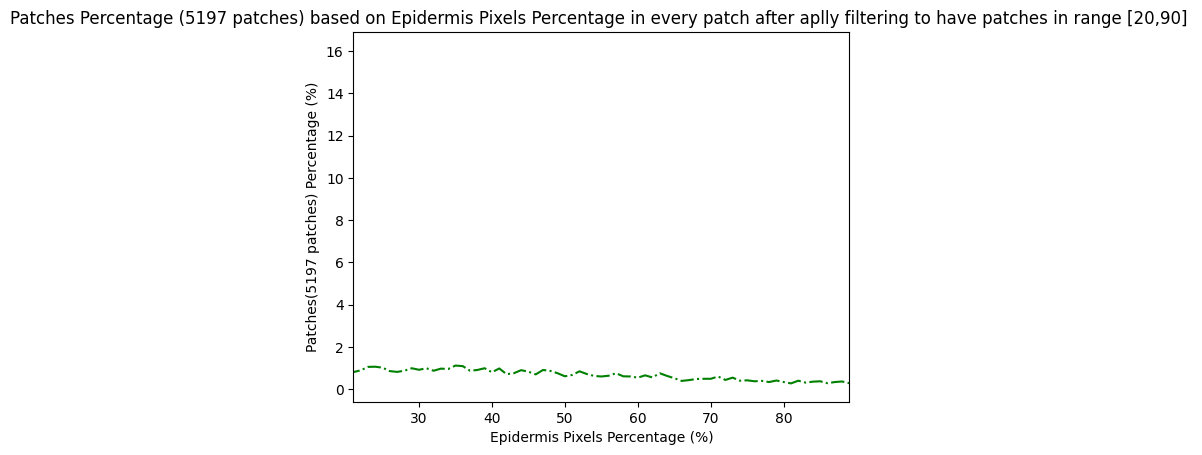

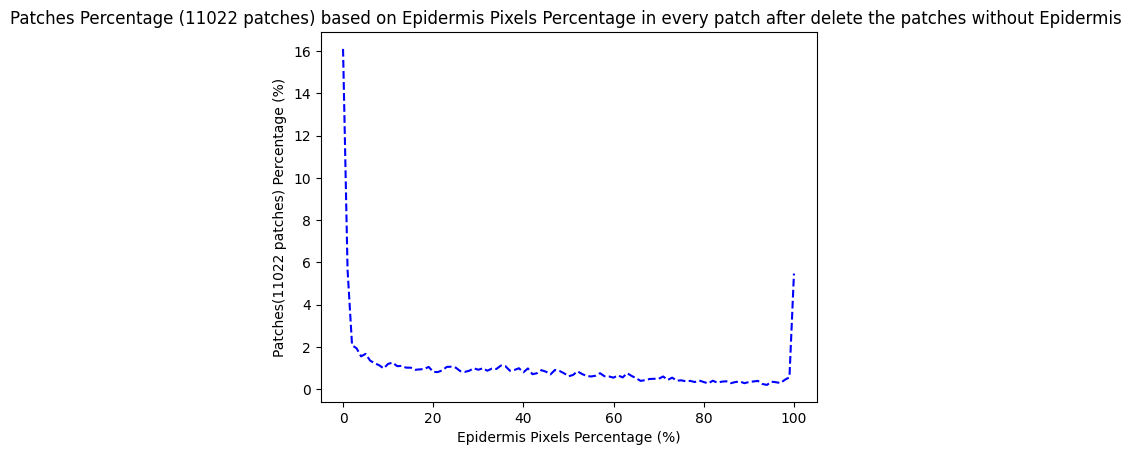

In [21]:
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df_filtered))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'green',linestyle='-.',ax = ax)
plt.title('Patches Percentage ('+str(len(df_filtered))+' patches) based on Epidermis Pixels Percentage in every patch after aplly filtering to have patches in range [20,90] ')
ax.set_xlim(21, 89)
plt.show()
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'blue',linestyle='--',ax = ax)
plt.title('Patches Percentage ('+str(len(df))+' patches) based on Epidermis Pixels Percentage in every patch after delete the patches without Epidermis ')
plt.show()

In [22]:
def image_generator(dataf, batch_size = 64):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(dataf.index.values, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = [] 

    for idx in batch:

        #get the masks. Note that masks are png files 

        mask = Image.open(dataf.iloc[idx]['mask_fullpath'])

        mask = np.array(mask)

        #preprocess the mask 
        mask[mask == 255] = 1 
        mask[mask == 0 ] = 0
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(dataf.iloc[idx]['img_fullpath'])
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [41]:
batch_size = 128



train_df, val_df = train_test_split(df_filtered, test_size=0.2)
train_df.index = range(len(train_df))
val_df.index = range(len(val_df))


train_generator = image_generator(train_df, batch_size = batch_size)
val_generator  = image_generator(val_df, batch_size = batch_size)

In [42]:
x, y= next(train_generator)

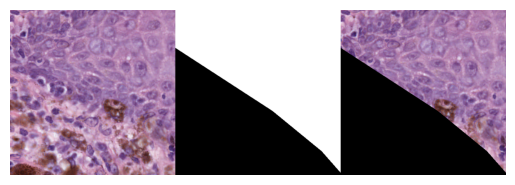

In [43]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [49]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [50]:
def unet(sz = (512, 512, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 2
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [51]:
model = unet()

In [52]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',np.round(logs.get('loss'),4),'val_loss=',np.round(logs.get('val_loss'),4),'mean_iou=',np.round(logs.get('mean_iou'),4),'val_mean_iou=',np.round(logs.get('val_mean_iou'),4))
        
        #choose a random test image and preprocess
        j = np.random.choice(test_df.index.values)
        raw = Image.open(test_df.iloc[j]['img_fullpath'])
        ground_truth = Image.open(test_df.iloc[j]['mask_fullpath'])
        raw = np.array(raw.resize((512, 512)))/255.
        ground_truth = np.array(ground_truth.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        pred_msk  = pred.squeeze()
        pred_msk = np.stack((pred_msk,)*3, axis=-1)
        
        pred_msk[pred_msk >= 0.5] = 1 
        pred_msk[pred_msk < 0.5] = 0 
        
        ground_truth = np.stack((ground_truth,)*3, axis=-1)
        #show the mask and the segmented image 
        
        combined = np.concatenate([raw, pred_msk, raw* pred_msk,raw*ground_truth], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

/tmp/ipykernel_33/3376737864.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


i= 1 loss= 0.6909 val_loss= 0.6865 mean_iou= 0.0019 val_mean_iou= 0.0
1/1 [==============================] - 1s 563ms/step


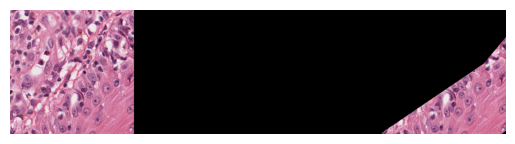

i= 2 loss= 0.6802 val_loss= 0.6785 mean_iou= 0.0027 val_mean_iou= 0.0075
1/1 [==============================] - 0s 89ms/step


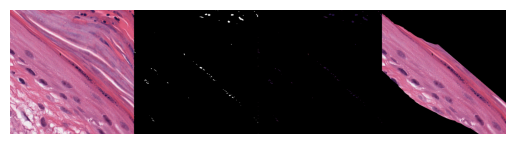

i= 3 loss= 0.6611 val_loss= 0.6393 mean_iou= 0.0848 val_mean_iou= 0.2746
1/1 [==============================] - 0s 124ms/step


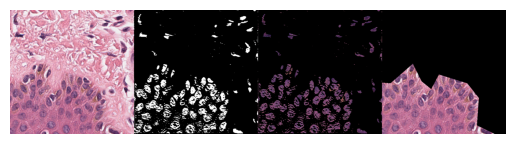

i= 4 loss= 0.6071 val_loss= 0.6397 mean_iou= 0.4376 val_mean_iou= 0.3232
1/1 [==============================] - 0s 124ms/step


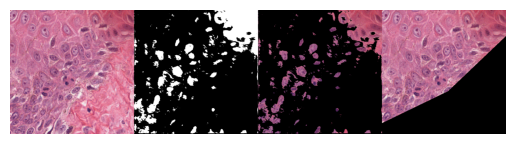

i= 5 loss= 0.5748 val_loss= 0.5621 mean_iou= 0.5559 val_mean_iou= 0.605
1/1 [==============================] - 0s 115ms/step


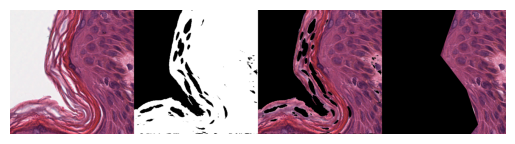

i= 6 loss= 0.5606 val_loss= 0.5505 mean_iou= 0.5892 val_mean_iou= 0.5971
1/1 [==============================] - 0s 114ms/step


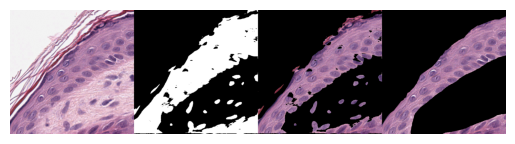

i= 7 loss= 0.551 val_loss= 0.5934 mean_iou= 0.6058 val_mean_iou= 0.5985
1/1 [==============================] - 0s 125ms/step


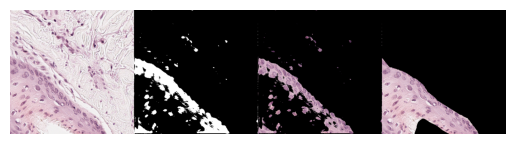

i= 8 loss= 0.5454 val_loss= 0.5263 mean_iou= 0.6038 val_mean_iou= 0.6448
1/1 [==============================] - 0s 142ms/step


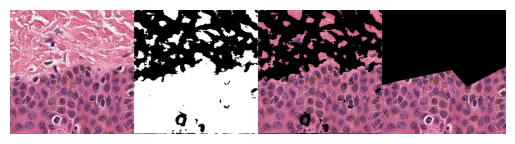

i= 9 loss= 0.5393 val_loss= 0.5337 mean_iou= 0.6085 val_mean_iou= 0.59
1/1 [==============================] - 0s 196ms/step


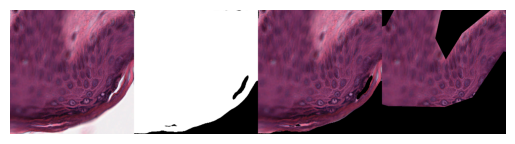

i= 10 loss= 0.5365 val_loss= 0.5253 mean_iou= 0.6127 val_mean_iou= 0.5792
1/1 [==============================] - 0s 144ms/step


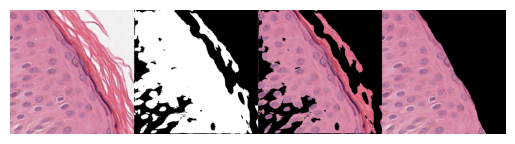

i= 11 loss= 0.5205 val_loss= 0.5294 mean_iou= 0.6218 val_mean_iou= 0.6459
1/1 [==============================] - 0s 152ms/step


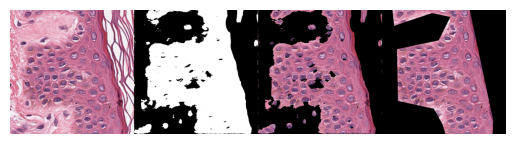

i= 12 loss= 0.5246 val_loss= 0.5299 mean_iou= 0.6133 val_mean_iou= 0.5948
1/1 [==============================] - 0s 103ms/step


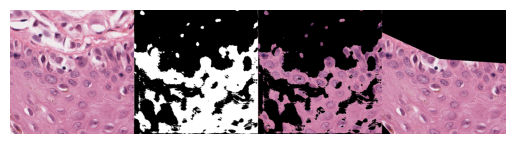

i= 13 loss= 0.5114 val_loss= 0.5407 mean_iou= 0.6259 val_mean_iou= 0.6324
1/1 [==============================] - 0s 191ms/step


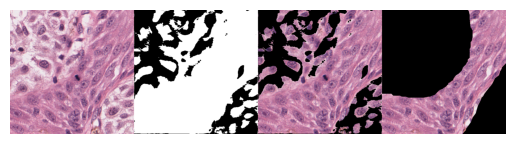

i= 14 loss= 0.5095 val_loss= 0.539 mean_iou= 0.6283 val_mean_iou= 0.636
1/1 [==============================] - 0s 173ms/step


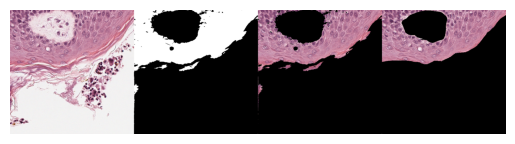

i= 15 loss= 0.5027 val_loss= 0.4955 mean_iou= 0.6322 val_mean_iou= 0.6536
1/1 [==============================] - 0s 186ms/step


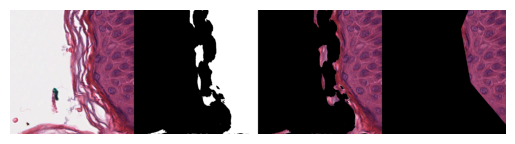

i= 16 loss= 0.4939 val_loss= 0.5013 mean_iou= 0.6391 val_mean_iou= 0.6662
1/1 [==============================] - 0s 204ms/step


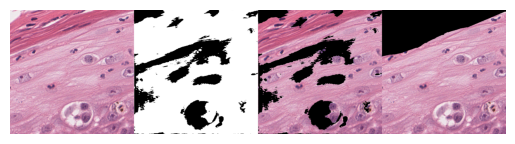

i= 17 loss= 0.4877 val_loss= 0.529 mean_iou= 0.641 val_mean_iou= 0.6387
1/1 [==============================] - 0s 194ms/step


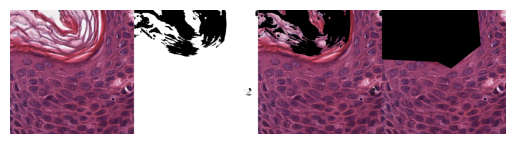

i= 18 loss= 0.4845 val_loss= 0.5047 mean_iou= 0.6425 val_mean_iou= 0.5788
1/1 [==============================] - 0s 223ms/step


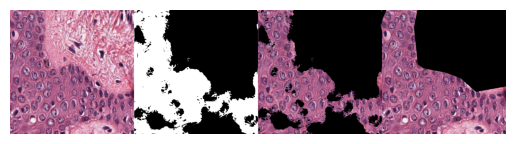

i= 19 loss= 0.477 val_loss= 0.4806 mean_iou= 0.6528 val_mean_iou= 0.6644
1/1 [==============================] - 0s 120ms/step


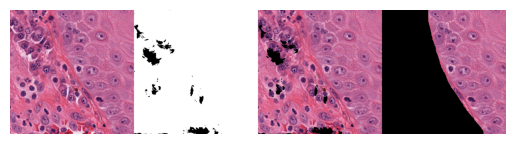

i= 20 loss= 0.4765 val_loss= 0.4727 mean_iou= 0.6461 val_mean_iou= 0.6186
1/1 [==============================] - 0s 170ms/step


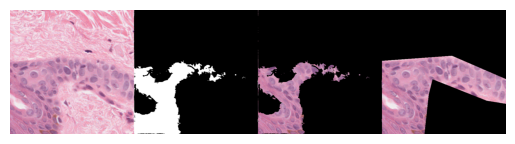

i= 21 loss= 0.4645 val_loss= 0.5686 mean_iou= 0.6575 val_mean_iou= 0.4977
1/1 [==============================] - 0s 212ms/step


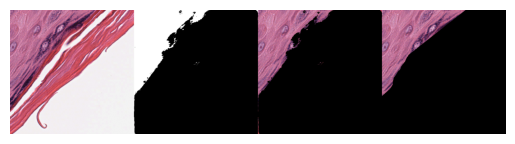

i= 22 loss= 0.4609 val_loss= 0.5266 mean_iou= 0.6634 val_mean_iou= 0.5598
1/1 [==============================] - 0s 172ms/step


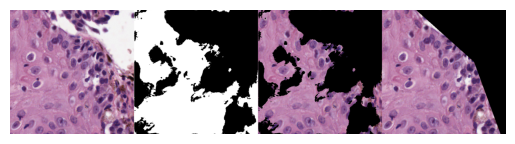

i= 23 loss= 0.4704 val_loss= 0.4806 mean_iou= 0.6421 val_mean_iou= 0.6697
1/1 [==============================] - 0s 180ms/step


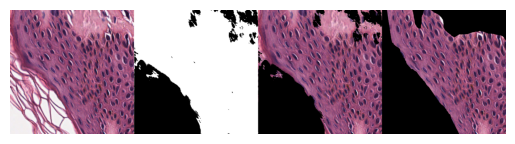

i= 24 loss= 0.4535 val_loss= 0.4485 mean_iou= 0.6629 val_mean_iou= 0.6617
1/1 [==============================] - 0s 139ms/step


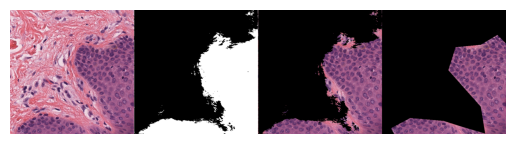

i= 25 loss= 0.4527 val_loss= 0.4886 mean_iou= 0.6593 val_mean_iou= 0.6036
1/1 [==============================] - 0s 221ms/step


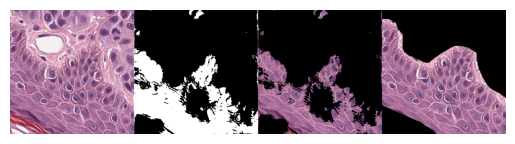

i= 26 loss= 0.4503 val_loss= 0.4719 mean_iou= 0.6608 val_mean_iou= 0.6774
1/1 [==============================] - 0s 196ms/step


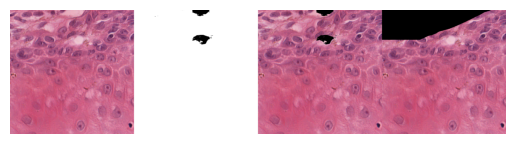

i= 27 loss= 0.4471 val_loss= 0.4397 mean_iou= 0.6628 val_mean_iou= 0.6902
1/1 [==============================] - 0s 236ms/step


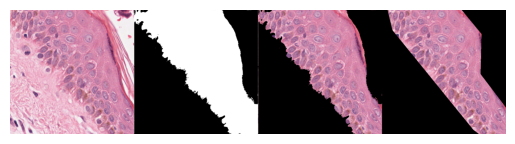

i= 28 loss= 0.4394 val_loss= 0.4675 mean_iou= 0.6745 val_mean_iou= 0.6792
1/1 [==============================] - 0s 207ms/step


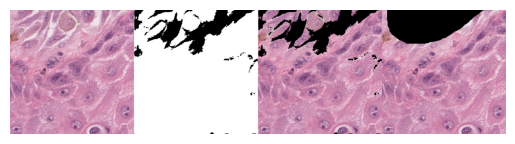

i= 29 loss= 0.4362 val_loss= 0.4674 mean_iou= 0.6737 val_mean_iou= 0.605
1/1 [==============================] - 0s 223ms/step


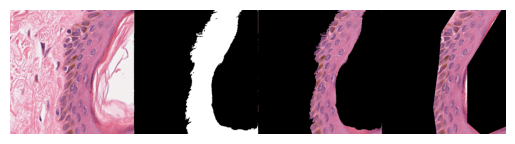

i= 30 loss= 0.4345 val_loss= 0.4328 mean_iou= 0.666 val_mean_iou= 0.6815
1/1 [==============================] - 0s 221ms/step


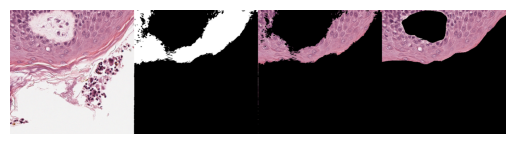

i= 31 loss= 0.432 val_loss= 0.4634 mean_iou= 0.6744 val_mean_iou= 0.6157
1/1 [==============================] - 0s 209ms/step


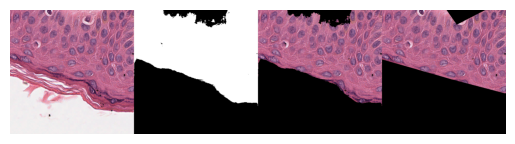

i= 32 loss= 0.4317 val_loss= 0.4527 mean_iou= 0.6722 val_mean_iou= 0.6313
1/1 [==============================] - 0s 202ms/step


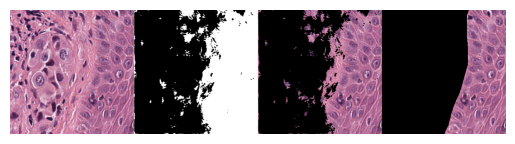

i= 33 loss= 0.4213 val_loss= 0.4393 mean_iou= 0.6839 val_mean_iou= 0.6485
1/1 [==============================] - 0s 187ms/step


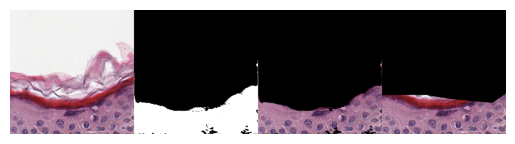

i= 34 loss= 0.434 val_loss= 0.4268 mean_iou= 0.6688 val_mean_iou= 0.6645
1/1 [==============================] - 0s 218ms/step


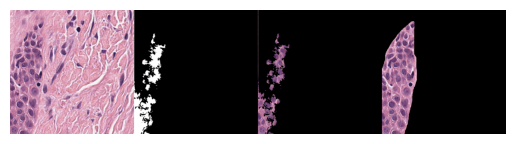

i= 35 loss= 0.417 val_loss= 0.4279 mean_iou= 0.6784 val_mean_iou= 0.6528
1/1 [==============================] - 0s 211ms/step


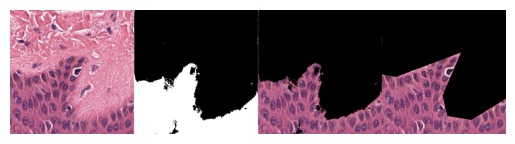

i= 36 loss= 0.4074 val_loss= 0.4212 mean_iou= 0.6937 val_mean_iou= 0.6688
1/1 [==============================] - 0s 184ms/step


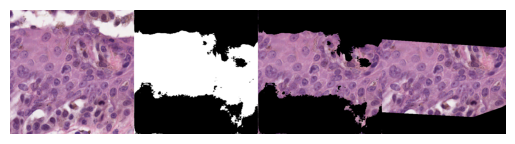

i= 37 loss= 0.4068 val_loss= 0.4435 mean_iou= 0.6897 val_mean_iou= 0.6389
1/1 [==============================] - 0s 213ms/step


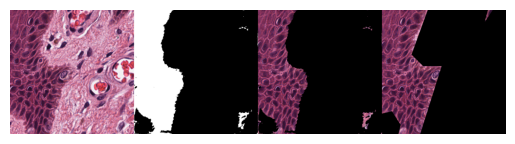

i= 38 loss= 0.4056 val_loss= 0.4086 mean_iou= 0.6867 val_mean_iou= 0.6898
1/1 [==============================] - 0s 302ms/step


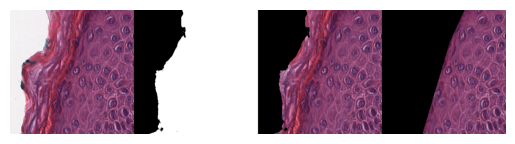

i= 39 loss= 0.4038 val_loss= 0.4568 mean_iou= 0.6901 val_mean_iou= 0.6824
1/1 [==============================] - 0s 208ms/step


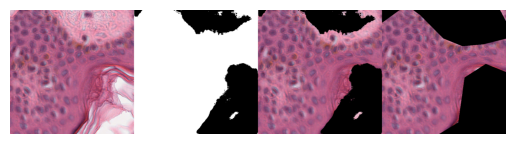

i= 40 loss= 0.3984 val_loss= 0.4354 mean_iou= 0.6966 val_mean_iou= 0.6911
1/1 [==============================] - 0s 227ms/step


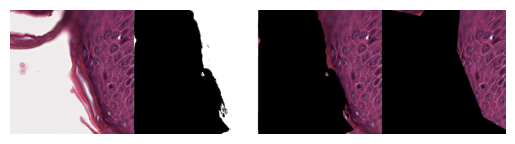

i= 41 loss= 0.4034 val_loss= 0.4105 mean_iou= 0.6927 val_mean_iou= 0.7095
1/1 [==============================] - 0s 212ms/step


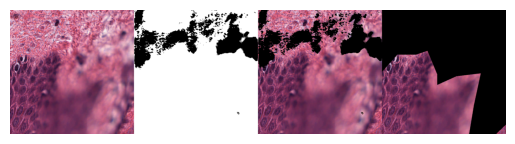

i= 42 loss= 0.3837 val_loss= 0.4154 mean_iou= 0.7122 val_mean_iou= 0.7086
1/1 [==============================] - 0s 210ms/step


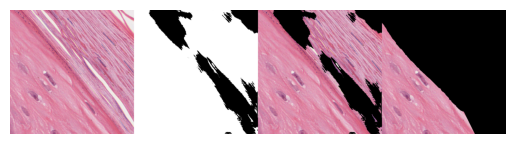

i= 43 loss= 0.3901 val_loss= 0.3804 mean_iou= 0.699 val_mean_iou= 0.7146
1/1 [==============================] - 0s 206ms/step


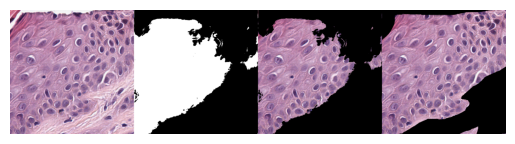

i= 44 loss= 0.3863 val_loss= 0.381 mean_iou= 0.7023 val_mean_iou= 0.7018
1/1 [==============================] - 0s 198ms/step


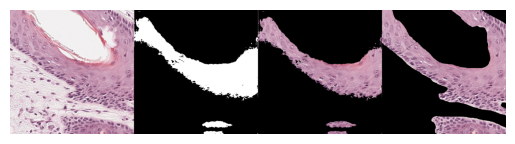

i= 45 loss= 0.3738 val_loss= 0.44 mean_iou= 0.7142 val_mean_iou= 0.63
1/1 [==============================] - 0s 182ms/step


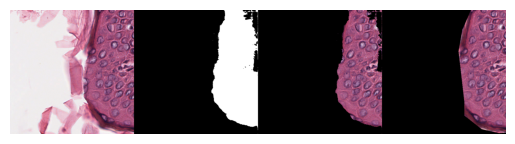

i= 46 loss= 0.3765 val_loss= 0.3926 mean_iou= 0.7084 val_mean_iou= 0.7151
1/1 [==============================] - 0s 217ms/step


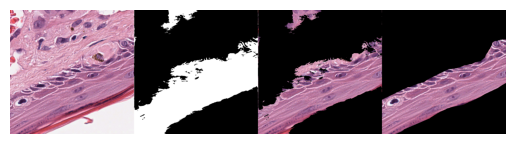

i= 47 loss= 0.3675 val_loss= 0.3736 mean_iou= 0.7217 val_mean_iou= 0.7315
1/1 [==============================] - 0s 195ms/step


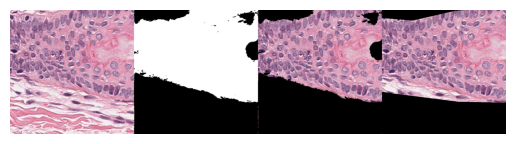

i= 48 loss= 0.3708 val_loss= 0.3619 mean_iou= 0.7164 val_mean_iou= 0.7319
1/1 [==============================] - 0s 212ms/step


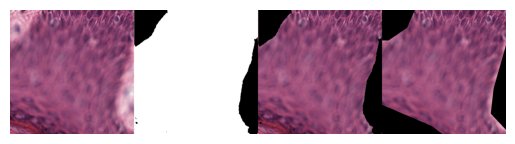

i= 49 loss= 0.3592 val_loss= 0.4674 mean_iou= 0.7249 val_mean_iou= 0.6247
1/1 [==============================] - 0s 177ms/step


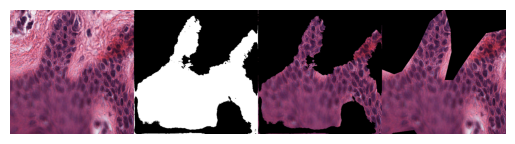

i= 50 loss= 0.369 val_loss= 0.418 mean_iou= 0.718 val_mean_iou= 0.7098
1/1 [==============================] - 0s 187ms/step


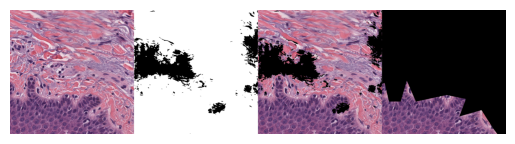

i= 51 loss= 0.342 val_loss= 0.4481 mean_iou= 0.7416 val_mean_iou= 0.6961
1/1 [==============================] - 0s 185ms/step


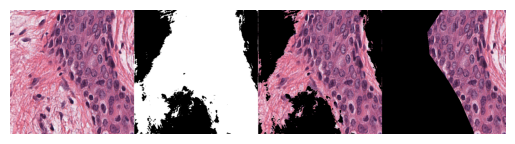

i= 52 loss= 0.356 val_loss= 0.3493 mean_iou= 0.7287 val_mean_iou= 0.7185
1/1 [==============================] - 0s 191ms/step


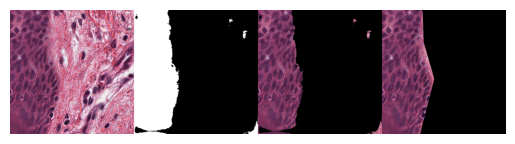

i= 53 loss= 0.344 val_loss= 0.3584 mean_iou= 0.7341 val_mean_iou= 0.7364
1/1 [==============================] - 0s 199ms/step


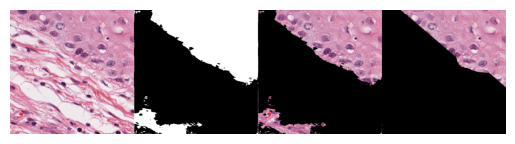

i= 54 loss= 0.3344 val_loss= 0.3406 mean_iou= 0.7498 val_mean_iou= 0.756
1/1 [==============================] - 0s 207ms/step


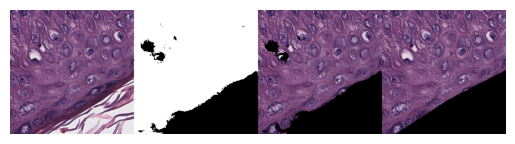

i= 55 loss= 0.3322 val_loss= 0.3304 mean_iou= 0.7459 val_mean_iou= 0.7598
1/1 [==============================] - 0s 208ms/step


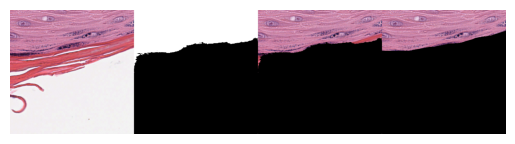

i= 56 loss= 0.3384 val_loss= 0.3234 mean_iou= 0.7417 val_mean_iou= 0.7604
1/1 [==============================] - 0s 196ms/step


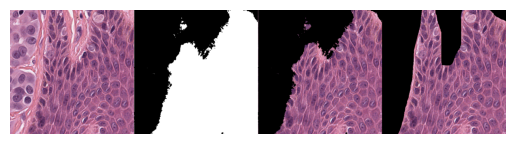

i= 57 loss= 0.3351 val_loss= 0.3345 mean_iou= 0.7426 val_mean_iou= 0.7321
1/1 [==============================] - 0s 220ms/step


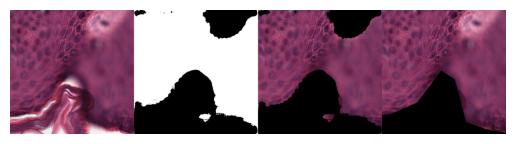

i= 58 loss= 0.3174 val_loss= 0.3387 mean_iou= 0.759 val_mean_iou= 0.7342
1/1 [==============================] - 0s 212ms/step


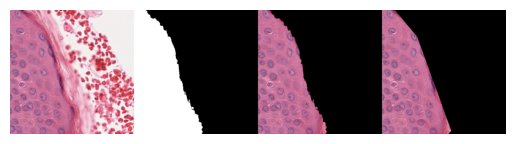

i= 59 loss= 0.3108 val_loss= 0.3169 mean_iou= 0.7618 val_mean_iou= 0.7628
1/1 [==============================] - 0s 216ms/step


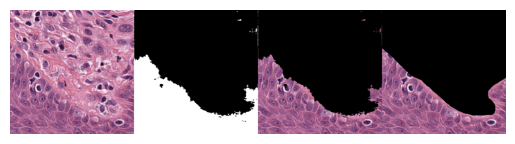

i= 60 loss= 0.3129 val_loss= 0.3702 mean_iou= 0.7612 val_mean_iou= 0.6946
1/1 [==============================] - 0s 197ms/step


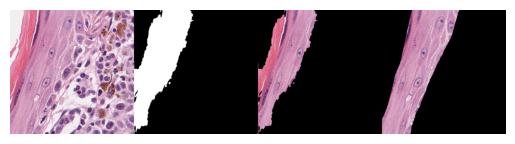

In [53]:
train_steps = len(train_df) //batch_size
val_steps = len(val_df) //batch_size
history = model.fit_generator(train_generator, 
                    epochs = 60, steps_per_epoch = train_steps,validation_data = val_generator, validation_steps = val_steps,
                    callbacks = build_callbacks(), verbose = 0)

In [54]:
model.save('unet_filtered.h5');

In [55]:
history.history


{'loss': [0.6909260153770447,
  0.6802369356155396,
  0.6610994935035706,
  0.607121467590332,
  0.5748178362846375,
  0.5606433153152466,
  0.5509709715843201,
  0.5454227924346924,
  0.5392583012580872,
  0.5364673733711243,
  0.5204585194587708,
  0.5246015787124634,
  0.5113739967346191,
  0.5094814896583557,
  0.502685546875,
  0.4939183294773102,
  0.48770684003829956,
  0.48450183868408203,
  0.4770428538322449,
  0.47646111249923706,
  0.4645404815673828,
  0.46086475253105164,
  0.4703541100025177,
  0.4534780979156494,
  0.4527255892753601,
  0.4503398835659027,
  0.44710755348205566,
  0.43940019607543945,
  0.4362312853336334,
  0.43446460366249084,
  0.4319564402103424,
  0.4317436218261719,
  0.4213294982910156,
  0.43398725986480713,
  0.4170219302177429,
  0.40740910172462463,
  0.40681424736976624,
  0.40563276410102844,
  0.4038378596305847,
  0.3984462022781372,
  0.4033743441104889,
  0.38374727964401245,
  0.3901119828224182,
  0.3863140940666199,
  0.3737959861755

In [56]:
import json
with open("history_unet_filtered.json", "w") as outfile:
    json.dump(history.history, outfile)

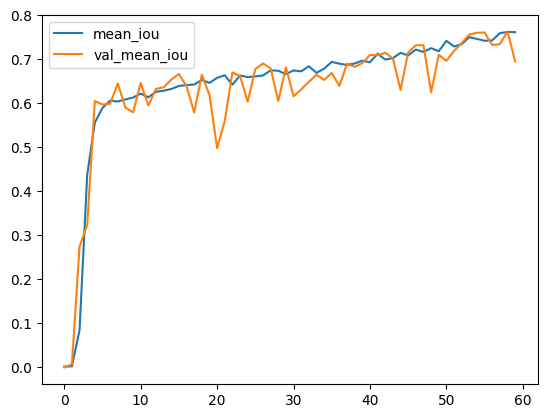

In [57]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.legend(['mean_iou', 'val_mean_iou'])
plt.show()

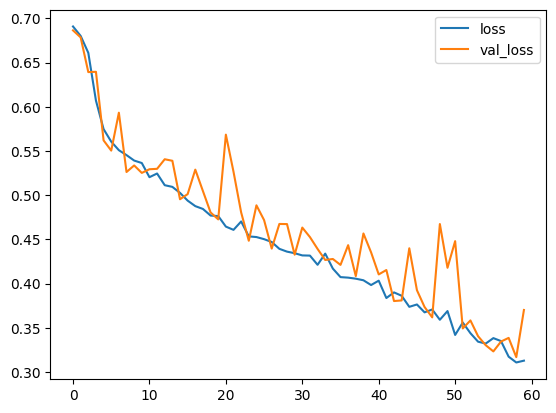

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()